In [1]:
#BLOCK 1

#Set Dependencies

%matplotlib inline
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import gmaps
import seaborn as sns

from keys import gkey

gmaps.configure(api_key=gkey)

In [5]:
#BLOCK 2

# File to Load (Remember to change these)

#Solar Installations from https://openpv.nrel.gov/search
#Climate Zone Data is from California Energy Commission. California Climate Zone Descriptions for New Buildings. July 1995.
#Climate Zone Details is from California Energy Commission. California Climate Zone Descriptions for New Buildings. July 1995.
#Sunny Days by https://www.currentresults.com/Weather/US/average-annual-sunshine-by-city.php included in Climate Zone csv
#Population data from
#Electricy Consumption by county from http://ecdms.energy.ca.gov/elecbycounty.aspx


#Read files Data from download
pv_data_df = pd.read_csv("Data/open_pv_california_2015.csv", encoding="ISO-8859-1")
climate_zip_code =pd.read_csv("Data/BuildingClimateZonesByZIPCode.csv", encoding="ISO-8859-1")
population = pd.read_csv("Data/population.csv",encoding="ISO-8859-1" )
electricity_consumption=pd.read_csv("Data/ElectricityConsumptionByCounty.csv",encoding="ISO-8859-1" )
climate_zone_details=pd.read_csv("Data/ClimateZoneDetails.csv",encoding="ISO-8859-1" )



C:\Users\aruba\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#BLOCK 3

#SOLAR PANEL DATA

#Clean data by only selecting the columns we need and filter by residential

solar_data = pv_data_df[["incentive_prog_names","size_kw","zipcode","install_type",
                         "cost_per_watt","utility_clean","county","annual_PV_prod"]]
solar_data=solar_data.dropna()

solar_data.loc[solar_data["install_type"] == "residential"]

solar_data=solar_data[["incentive_prog_names","size_kw","zipcode",
                         "cost_per_watt","utility_clean","county","annual_PV_prod"]]


In [7]:
#BLOCK 4

#MERGE IN THE CLIMATE ZONE BY ZIP CODE, POPULATION AND ELECTRICITY CONSUMPTION

#Merge Solar Data with Climate Zone zip code
solar_cz_data = pd.merge(solar_data, climate_zip_code, on="zipcode")

#Merge in population and electricity consumption
solar_cz_pop = pd.merge(solar_cz_data, population, on="county")
solar_cz_pop_elec = pd.merge(solar_cz_pop, electricity_consumption, on="county" )

#MAIN DATA BASE WITH ALL INFORMATION NEEDED TO START ANALYSIS
solar_summary=solar_cz_pop_elec.rename(columns = {"incentive_prog_names": "Incentive Program", 
                                                      "size_kw": "System Size kw", 
                                                      "cost_per_watt": "Cost Per Watt",
                                                     "utility_clean": "Utility Company",
                                                      "county": "County", 
                                                      "annual_PV_prod": "Solar Energy Production kwh",
                                                      "population": "Population",
                                                      "housing_units": "Housing Units",
                                                      "2015 Millions of kWh (GWh)": "Electricity Production Millions of kWh (GWh)"
                                                     })
# Save as a csv
solar_summary.to_csv("Data/solar_summary.csv", encoding="utf-8", index=False)
solar_summary.head()


,Incentive Program,System Size kw,zipcode,Cost Per Watt,Utility Company,County,Solar Energy Production kwh,Building CZ,Population,Housing Units,land_area_sq_mi,Electricity Production Millions of kWh (GWh)
0,California Public Utilities Commission (Non-CS...,7.0672,93720,3.162497,Pacific Gas & Electric Company,Fresno,11080.851980,13,930450,315531,5958,2674.195219
1,California Public Utilities Commission (Non-CS...,6.5604,93720,1.704481,Pacific Gas & Electric Company,Fresno,9368.967142,13,930450,315531,5958,2674.195219
2,California Public Utilities Commission (Non-CS...,6.5604,93720,1.704481,Pacific Gas & Electric Company,Fresno,9008.908333,13,930450,315531,5958,2674.195219
3,California Public Utilities Commission (Non-CS...,9.9320,93720,4.063711,Pacific Gas & Electric Company,Fresno,14009.671590,13,930450,315531,5958,2674.195219
4,California Public Utilities Commission (Non-CS...,8.2005,93720,4.208194,Pacific Gas & Electric Company,Fresno,10891.724510,13,930450,315531,5958,2674.195219


In [8]:
#BLOCK 5

#SHOW DATA GROUPBY CLIMATE ZONE 


cz_count=pd.DataFrame(solar_summary["Building CZ"].value_counts()).reset_index()
cz_count=cz_count.rename(columns = {"index": "Climate Location Zone","Building CZ": "PV Installations"})
cz_count=cz_count.sort_values("Climate Location Zone").set_index("Climate Location Zone")

#Making a new database to insert all information
solardata_summary=cz_count

solardata_summary["System Size kw"]=round(solar_summary.groupby("Building CZ")["System Size kw"].mean(),2)
solardata_summary["Solar Energy Production kwh"]=round(solar_summary.groupby("Building CZ")["Solar Energy Production kwh"].sum())
solardata_summary["Cost Per Watt"]=round(solar_summary.groupby("Building CZ")["Cost Per Watt"].mean(),2)
solardata_summary["Population Size"]=round(solar_summary.groupby("Building CZ")["Population"].mean())
solardata_summary["Housing Units"]=round(solar_summary.groupby("Building CZ")["Housing Units"].mean())
solardata_summary["Ratio of Installations:Housing Units"]=round(100*solardata_summary["PV Installations"]/solardata_summary["Housing Units"], 2)
solardata_summary["Electricity (Not Solar) Production Millions of kWh (GWh)"]=round(solar_summary.groupby("Building CZ")["Electricity Production Millions of kWh (GWh)"].sum(),2)

solardata_summary=pd.DataFrame(solardata_summary)
solardata_summary


,PV Installations,System Size kw,Solar Energy Production kwh,Cost Per Watt,Population Size,Housing Units,Ratio of Installations:Housing Units,Electricity (Not Solar) Production Millions of kWh (GWh)
Climate Location Zone,,,,,,,,
1,108,5.20,726761.0,4.73,209001.0,92015.0,0.12,6.267468e+04
2,1640,7.00,16603626.0,5.12,346640.0,147471.0,1.11,1.512592e+06
3,3195,7.28,34108696.0,5.08,970061.0,374428.0,0.85,6.335256e+06
4,4958,6.26,46239079.0,4.82,1451850.0,517860.0,0.96,1.562035e+07
5,1501,6.54,15733500.0,4.88,341473.0,133856.0,1.12,1.044654e+06
6,5501,7.22,58172967.0,4.78,4685110.0,1639573.0,0.34,5.526495e+07
7,662,6.75,6807486.0,4.68,3095313.0,1164786.0,0.06,4.556752e+06
8,8447,6.30,79851034.0,4.84,5419311.0,1896784.0,0.45,9.871762e+07
9,8395,6.86,86698586.0,4.89,8381716.0,2939764.0,0.29,1.468504e+08


In [9]:
#BLOCK 6

#CLIMATE ZONES/lOCATION ZONES DETAILS DATA
climate_zone_details=climate_zone_details.rename(columns = {"climate_zone": "Climate Location Zone", 
                                                      "reference_city": "Reference City", 
                                                      "cz_location": "Climate Zone Ref City",
                                                      "sunny_days": "Sunny Days",
                                                      "highest_temp_rec": "Highest Temp Rec", 
                                                      "lowest_temp_rec": "Lowest Temp Rec",
                                                      "Latitude": "Latitude",
                                                      "Longitude": "Longitude",
                                                      "Elevation": "Elevation",
                                                      "HDd": "Heating Degree Days", 
                                                      "CDD": "Cooling Degree Days",
                                                     })
climate_zone_details.to_csv("Data\Solar_Greenhouse.csv", encoding ="utf-8", index=False)
climate_zone_details.head()

,Climate Location Zone,Reference City,Climate Zone Ref City,Sunny Days,Highest Temp Rec,Lowest Temp Rec,Latitude,Longitude,Elevation,HDD,Cooling Degree Days
0,1,Eureka,1-Eureka,179,85,21,41.30,124.28,43,4496,0
1,2,Napa,2-Napa,260,113,14,38.28,122.27,60,2844,456
2,3,Oakland,3-Oakland,261,113,14,37.75,122.20,10,2909,128
3,4,San Jose,4-San Jose,257,109,19,37.35,121.90,70,2335,574
4,5,Santa Maria,5-Santa Maria,283,108,20,34.93,120.42,230,2844,456


In [10]:
#BLOCK 7

#MERGE DATA FROM SOLAR DATA SUMMARY AND CLIMATE LOCATION ZONE DETAILS

summary_by_climatelocation=pd.merge(solardata_summary, climate_zone_details, on="Climate Location Zone")
summary_by_climatelocation.head()

,Climate Location Zone,PV Installations,System Size kw,Solar Energy Production kwh,Cost Per Watt,Population Size,Housing Units,Ratio of Installations:Housing Units,Electricity (Not Solar) Production Millions of kWh (GWh),Reference City,Climate Zone Ref City,Sunny Days,Highest Temp Rec,Lowest Temp Rec,Latitude,Longitude,Elevation,HDD,Cooling Degree Days
0,1,108,5.20,726761.0,4.73,209001.0,92015.0,0.12,62674.68,Eureka,1-Eureka,179,85,21,41.30,124.28,43,4496,0
1,2,1640,7.00,16603626.0,5.12,346640.0,147471.0,1.11,1512592.29,Napa,2-Napa,260,113,14,38.28,122.27,60,2844,456
2,3,3195,7.28,34108696.0,5.08,970061.0,374428.0,0.85,6335256.20,Oakland,3-Oakland,261,113,14,37.75,122.20,10,2909,128
3,4,4958,6.26,46239079.0,4.82,1451850.0,517860.0,0.96,15620345.57,San Jose,4-San Jose,257,109,19,37.35,121.90,70,2335,574
4,5,1501,6.54,15733500.0,4.88,341473.0,133856.0,1.12,1044653.95,Santa Maria,5-Santa Maria,283,108,20,34.93,120.42,230,2844,456


In [11]:
#BLOCK 8

#GRAPH 1 GEOMAP SHOWING THE LOCATION OF CLIMATE ZONES

Lat = climate_zone_details["Latitude"]
Long = climate_zone_details["Longitude"]
ref_city = climate_zone_details["Climate Zone Ref City"]
city_coordinates = []
cities = []


for i in range(len(Lat)):
    coordinates = (Lat[i],-Long[i])
    city_coordinates.append(coordinates)
    city = ref_city[i]
    cities.append(city)
city_coordinates
cities

figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

# Assign the marker layer to a variable
markers = gmaps.marker_layer(city_coordinates,info_box_content=cities)
# Add the layer to the map
fig.add_layer(markers)
fig

NameError: name 'gmaps' is not defined

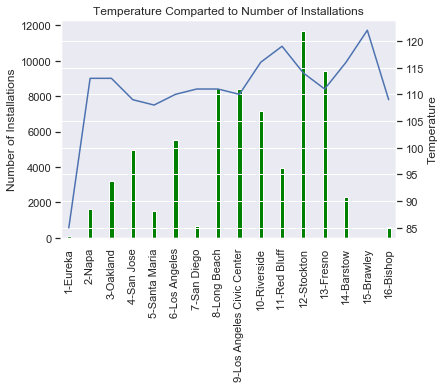

In [12]:
#BLOCK 9
sns.set()
#1 HYPTOHESIS TEMPERATURE OF CLIMATE/LOCATION ZONES WILL IMPACT THE NUMBER OF INSTALLATIONS AND THE SYSTEM SIZE
fig = plt.figure()


ax = fig.add_subplot(111)

labels=summary_by_climatelocation["Climate Zone Ref City"]

summary_by_climatelocation["PV Installations"].plot(x=labels, kind='bar', width =.20, color= "green")

ax1 = ax.twinx()
ax1=summary_by_climatelocation["Highest Temp Rec"].plot(secondary_y=True)
ax.grid()
ax.set_title("Temperature Comparted to Number of Installations")
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("Number of Installations")
ax1.set_ylabel("Temperature")

plt.savefig("TemperatureVSInstallations.png")
plt.show()

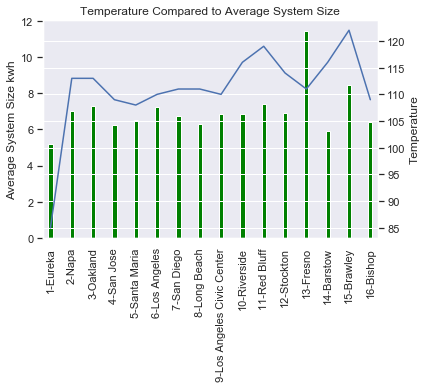

In [13]:
#BLOCK 10
sns.set()
#1HYPOTHESIS: CLIMATE ZONE WILL IMPACT SYTEM SIZE
sns.set()
#1 HYPTOHESIS TEMPERATURE OF CLIMATE/LOCATION ZONES WILL IMPACT THE NUMBER OF INSTALLATIONS
fig = plt.figure()


ax = fig.add_subplot(111)

labels=summary_by_climatelocation["Climate Zone Ref City"]

summary_by_climatelocation["System Size kw"].plot(x=labels, kind='bar', width =.20, color= "green")

ax1 = ax.twinx()
ax1=summary_by_climatelocation["Highest Temp Rec"].plot(secondary_y=True)
ax.grid()
ax.set_title("Temperature Compared to Average System Size")
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("Average System Size kwh")
ax1.set_ylabel("Temperature")

plt.savefig("TempSizeClimate.png")
plt.show()

In [13]:
#BLOCK 11

#TEST STATISTICS USING GOOD OF FITNESS TEST
#The Highes Recorded Temperature is from the Reference City and we will treat as the average for the entire Climate Zone with
#the reference City

#New dataframe to look at the average of installations by Climate Zone and Reference City and highest temperature

test_data=summary_by_climatelocation["Climate Zone Ref City"]
test_data=pd.DataFrame(test_data)
test_data["Highest Temp (Average)"]=summary_by_climatelocation["Highest Temp Rec"]
test_data["PV Installations"]=summary_by_climatelocation["PV Installations"]
#total_installations=solardata_summary["PV Installations"].count()
test_data["Average PV Installations (Proportions)"]=round(test_data["PV Installations"]/test_data["PV Installations"].sum(),3)

sort_test_data=test_data.sort_values(["Highest Temp (Average)"],ascending = False).reset_index()
sort_test_data=pd.DataFrame(sort_test_data)

statistic_data=sort_test_data.drop(["index"], axis=1)
statistic_data["Proportion Label"]=["P1","P2","P3","P4","P5","P6","P7","P8","P9","P10","P11","P12","P13","P14","P15","P16"]


In [24]:
#BLOCK 12
#TEST STATISTICS USING GOOD OF FITNESS TEST Cont. 

top5_high=statistic_data.head()
top5_high_temp=pd.DataFrame(top5_high)
top5_high_temp

,Climate Zone Ref City,Highest Temp (Average),PV Installations,Average PV Installations (Proportions),Proportion Label
0,15-Brawley,122,8,0.000,P1
1,11-Red Bluff,119,3970,0.057,P2
2,10-Riverside,116,7178,0.103,P3
3,14-Barstow,116,2306,0.033,P4
4,12-Stockton,114,11697,0.168,P5


In [50]:
#BLOCK 13

#TEST STATISTICS USING GOOD OF FITNESS TEST Cont. 

#Null Hypothesis
#H0: P1=P2=P3=P4=P5
#H1: At least one of the proportion is diff

calc_data=top5_high_temp["Climate Zone Ref City"]
calc_data=pd.DataFrame(calc_data)
calc_data["Proportion Label"]=top5_high_temp["Proportion Label"]
calc_data["Proportions"]=top5_high_temp["Average PV Installations (Proportions)"]
calc_data["Observed"]=top5_high_temp["PV Installations"]

total_intallations=top5_high_temp["PV Installations"].sum()
print(total_intallations)

calc_data["Expected"]=round(top5_high_temp["Average PV Installations (Proportions)"].apply(lambda x: x*total_intallations),0)

calc_data.drop(0)

25159


,Climate Zone Ref City,Proportion Label,Proportions,Observed,Expected
1,11-Red Bluff,P2,0.057,3970,1434.0
2,10-Riverside,P3,0.103,7178,2591.0
3,14-Barstow,P4,0.033,2306,830.0
4,12-Stockton,P5,0.168,11697,4227.0


In [52]:
#BLOCK 14
#TEST STATISTICS USING GOOD OF FITNESS TEST Cont. 
critical_value = stats.chi2.ppf(q = 0.95, df = 3)
print(critical_value)

stats.chisquare(f_obs=calc_data["Observed"], f_exp=calc_data["Expected"])

7.814727903251179


C:\Users\aruba\Anaconda3\lib\site-packages\scipy\stats\stats.py:4567: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


Power_divergenceResult(statistic=inf, pvalue=0.0)

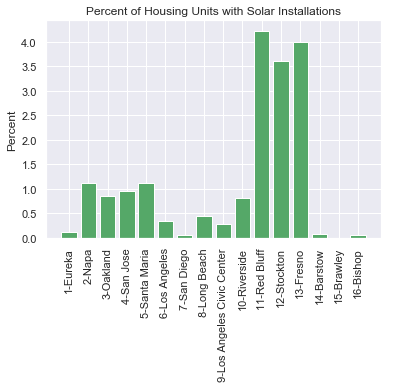

In [21]:
#BLOCK 15
sns.set()
#3 HYPOTHESIS: CITIES IN THE CENTRAL VALLEY OF CALIFORNIA WILL HAVE MORE SOLAR INSTALLATIONS

# GRAPH 2 SCATTER PLOT SHOWING THE NORMALIZED AMOUNT OF INSTALLATIONS BY CLIMATE ZONE
ratio_install_housing = solardata_summary["Ratio of Installations:Housing Units"]
plt.title("Percent of Housing Units with Solar Installations")
plt.ylabel("Percent")
plt.xticks(rotation=90)

plt.bar(cities, ratio_install_housing, color='g', alpha=1, align="center")

plt.savefig("PerHousingUnitsVSSolarInstallations.png")
plt.show()

In [15]:
#BlOCK 16 
# GRAPH 3 HEAT MAP WITH THE INSTALLATIONS BY CLIMATE/LOCATION ZONE

figure_layout1 = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig1 = gmaps.figure(layout=figure_layout1)

# Assign the marker layer to a variable
heat_layer = gmaps.heatmap_layer(city_coordinates, weights=ratio_install_housing, 
                                 dissipating=False, max_intensity=5,
                                 point_radius = .5)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 5
heat_layer.point_radius = .5

fig1.add_layer(heat_layer)

fig1


NameError: name 'gmaps' is not defined

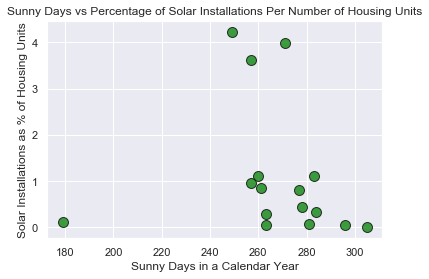

In [20]:
#BLOCK 17

#4 HYPOTHESIS:  CLIMATE ZONES WITH MORE SUNNY DAYS WILL HAVE A HIGHER PERCENTAGE OF SOLAR INSTALLATIONS
# PER NUMBER OF HOUSING UNITS
# GRAPH 4:  CLIMATE ZONES SUNNY DAYS VS. NORMALIZED INSTALLATIONS 

sns.set()

sunny_days = summary_by_climatelocation["Sunny Days"]
plt.scatter(sunny_days, ratio_install_housing, marker="o", facecolors="green", edgecolors="black",
            alpha=0.75, label='x', linewidth = 1, s = 100)

plt.title("Sunny Days vs Percentage of Solar Installations Per Number of Housing Units")
plt.xlabel("Sunny Days in a Calendar Year")
plt.ylabel("Solar Installations as % of Housing Units")

plt.savefig("SunnyDaysVSNumberHousing.png")
plt.show()


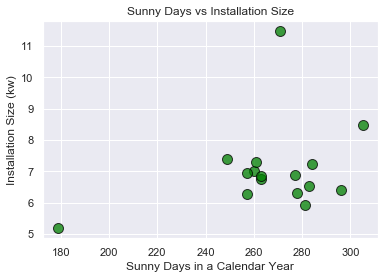

In [22]:
#BLOCK 18

#3 HYPOTHESIS:  CLIMATE ZONES WITH MORE SUNNY DAYS WILL HAVE SMALLER SOLAR INSTALLATIONS
# GRAPH 5: CLIMATE ZONES SUNNY DAYS VS INSTALLATION SIZE

sns.set()

install_size = summary_by_climatelocation["System Size kw"]
plt.scatter(sunny_days, install_size, marker="o", facecolors="green", edgecolors="black",
            alpha=0.75, label='x', linewidth = 1, s = 100)

plt.title("Sunny Days vs Installation Size")
plt.xlabel("Sunny Days in a Calendar Year")
plt.ylabel("Installation Size (kw)")

plt.savefig("SunnyDaysVSSystemSize.png")
plt.show()

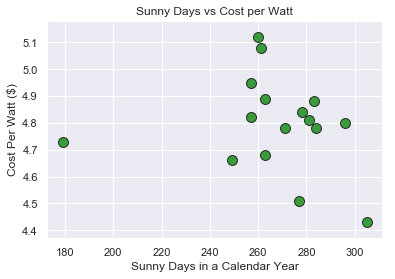

In [25]:
#BLOCK 19

#4 HYPOTHESIS:  CLIMATE ZONES WITH MORE SUNNY DAYS WILL HAVE A LOWER COST PER WATT FOR SOLAR INSTALLATIONS

# GRAPH 6:  CLIMATE ZONES SUNNY DAYS VS COST PER WATT

sns.set()

cost_per_watt = summary_by_climatelocation["Cost Per Watt"]
plt.scatter(sunny_days, cost_per_watt, marker="o", facecolors="green", edgecolors="black",
            alpha=0.75, label='x', linewidth = 1, s = 100)

plt.title("Sunny Days vs Cost per Watt")
plt.xlabel("Sunny Days in a Calendar Year")
plt.ylabel("Cost Per Watt ($)")

plt.savefig("SunnyDaysVSCostWatt.png")
plt.show()

In [28]:
#DATAFRAME ON CALCULATIONS ON GREENHOUSE EMMISSIONS AND THE IMPACT
#Calculating greenhouse emmissions Electricity: (VARIABLE) kWh per home × 998 lbs CO2 per megawatt-hour generated × (1/(1-0.071)) MWh generated/MWh delivered × 1 MWh/1,000 kWh × 1 metric ton/2,204.6 lb = 5.734 metric tons CO2/home



In [ ]:
#AMOUNT OF GREENHOUSE EMISSIONS
greenhousefactor=0.000487287
treefactor=
est_greenEmissions_ifnot_solar=[]
trees_needed_per_kw=[]


